In [34]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

In [35]:
import findspark
findspark.init()

In [36]:
spark = SparkSession.builder.master("local[*]").appName("spark").getOrCreate()

In [37]:
sc = spark.sparkContext

In [38]:
dataset_parent_dir = 'D:/CUFE/S23/CMPN451/Project/'

In [39]:
league_min_df_path = dataset_parent_dir + 'matches-1k.json'
league_df = spark.read.json(league_min_df_path)

In [40]:
league_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- gameCreation: long (nullable = true)
 |-- gameDuration: long (nullable = true)
 |-- gameId: long (nullable = true)
 |-- gameMode: string (nullable = true)
 |-- gameType: string (nullable = true)
 |-- gameVersion: string (nullable = true)
 |-- mapId: long (nullable = true)
 |-- participantIdentities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- participantId: long (nullable = true)
 |    |    |-- player: struct (nullable = true)
 |    |    |    |-- accountId: string (nullable = true)
 |    |    |    |-- currentAccountId: string (nullable = true)
 |    |    |    |-- currentPlatformId: string (nullable = true)
 |    |    |    |-- matchHistoryUri: string (nullable = true)
 |    |    |    |-- platformId: string (nullable = true)
 |    |    |    |-- profileIcon: long (nullable = true)
 |    |    |    |-- summonerId: string (nullable = true)
 |    |    |    |-- summo

In [41]:
import json
dataset = json.load(open(league_min_df_path))
participant_int_data = np.empty((10000, 6), dtype=int)
match_int_data = np.empty((1000, 3), dtype=int)
participant_role = ['']*10000
participant_lane = ['']*10000
match_mode = ['']*1000

for i , match in enumerate(dataset[1:]):
    for j, participant in enumerate(match['participants']):
        stats = participant['stats']
        damage_dealt = stats['totalDamageDealtToChampions']
        damage_taken = stats['totalDamageTaken']
        win = stats['win']
        kills = stats['kills']
        deaths = stats['deaths']
        assists = stats['assists']
        role = participant['timeline']['role']
        participant_int_data[i*10+j] = [damage_dealt, damage_taken, kills, deaths, assists, win]
        participant_role[i*10+j] = role
        participant_lane[i*10+j] = participant['timeline']['lane']

    match_int_data[i] = [match['mapId'], match['gameDuration'], match['seasonId']]
    match_mode[i] = match['gameMode']

# data_participant = []
# def extract_match_participants_data(match):
#     for participant in match['participants']:
#         stats = participant['stats']
#         damage_dealt = stats['totalDamageDealtToChampions']
#         damage_taken = stats['totalDamageTaken']
#         win = stats['win']
#         kills = stats['kills']
#         deaths = stats['deaths']
#         assists = stats['assists']
#         role = participant['element']['timeline']['role']
#         data_participant.append((damage_dealt, damage_taken, kills, deaths, assists, win, role))
#     return data_participant

# data_match = []
# def extract_match_data(match):
#     maap = match['mapId']
#     mode = match['gameMode']
#     duration = match['gameDuration']
#     seasonId = match['seasonId']
#     data_match.append((maap, duration, seasonId, mode))
#     return data_match

In [42]:
# data_participant = league_rdd.flatMap(extract_match_participants_data).collect()
# data_match = league_rdd.flatMap(extract_match_data).collect()
np_data_participant = participant_int_data
np_data_match = match_int_data

Text(0.5, 1.0, 'Relationship between total damage taken and total damage dealt')

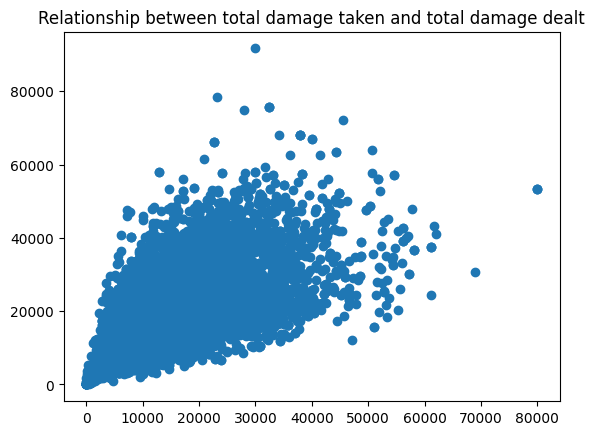

In [43]:
# Relationship between total damage taken and total damage dealt
tdd = np_data_participant[:,0]
tdt = np_data_participant[:,1]

plt.scatter(tdd, tdt)
plt.title('Relationship between total damage taken and total damage dealt')
# conclusion: ratio between damage taken and damage dealt is bounded by 0.2 and 2
# which means that there is positive correlation between damage taken and damage dealt
# which indicates that the game is balanced

In [ ]:
def plot_pdf(data, title, xlabel, ylabel):
    plt.hist(data, density=True, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_11104\4291918621.py:1: RuntimeWarning: invalid value encountered in divide
  plot_pdf(np.divide(tdd, tdt), "Damage Dealt / Taken", "Damage Dealt / Taken","Probability")


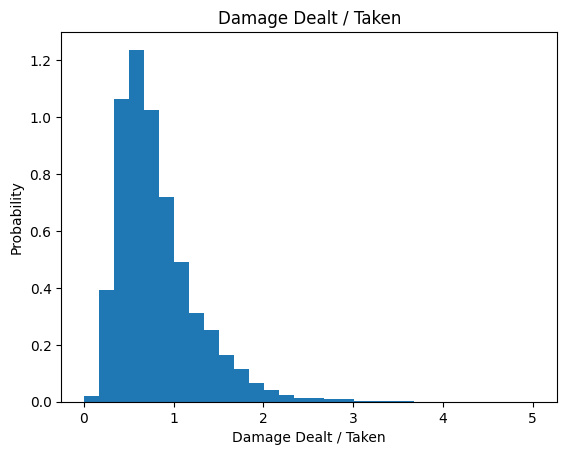

In [44]:
plot_pdf(np.divide(tdd, tdt), "Damage Dealt / Taken", "Damage Dealt / Taken","Probability")
# This validates the previous conclusion
# we can see that the ratio is bounded by 0.2 and 2
# and it is noticeable  to that it takes the shape of a normal distribution

Text(0.5, 1.0, 'Relationship between total damage taken and win')

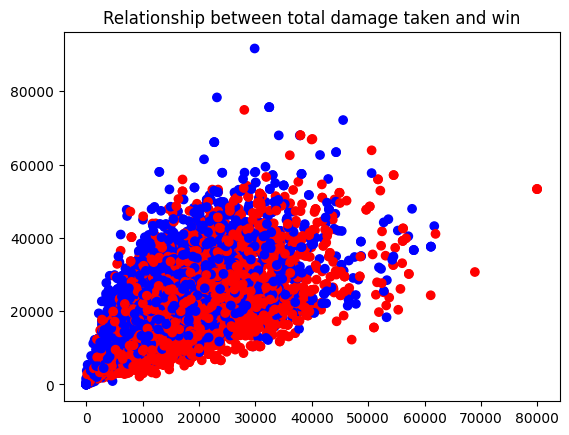

In [45]:
# Relationship between total damage taken and win
win = np_data_participant[:,5]
plt.scatter(tdd, tdt, color = ['red' if w == 1 else 'blue' for w in win])
plt.title('Relationship between total damage taken and win')
# this is the same as the first plot but with the win/lose factor
# it makes sense, as we can see that players who win tend to deal more damage than players who lose

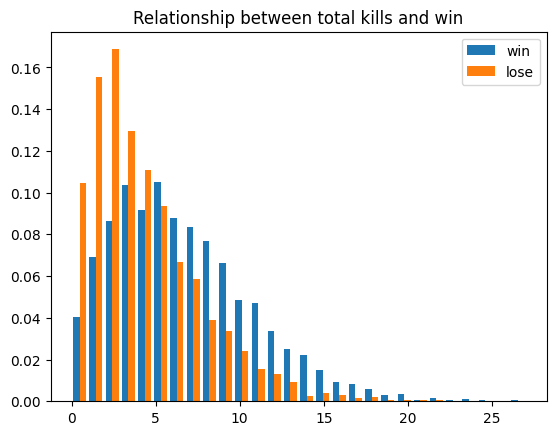

In [46]:
# Relationship between total kills and win
kills = np_data_participant[:,2]
plt.hist([kills[win == 1], kills[win == 0]], density=True, bins=kills.max()+1)
plt.legend(['win', 'lose'])
plt.title('Relationship between total kills and win')
plt.show()
# conclusion: the more kills you have, the more likely you are to win

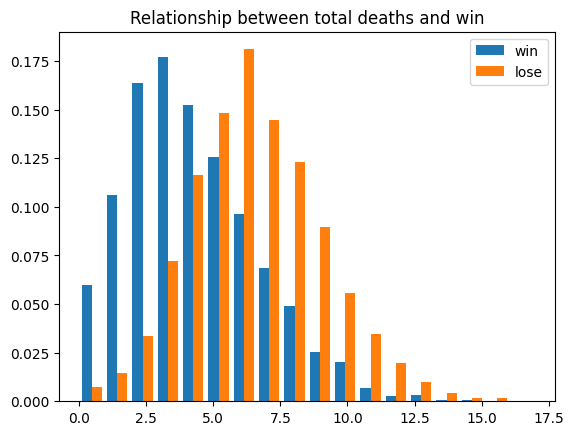

In [47]:
# Relationship between total deaths and win
deaths = np_data_participant[:,3]
plt.hist([deaths[win == 1], deaths[win == 0]], density=True, bins=deaths.max()+1)
plt.legend(['win', 'lose'])
plt.title('Relationship between total deaths and win')
plt.show()
# conclusion: the more deaths you have, the more likely you are to lose

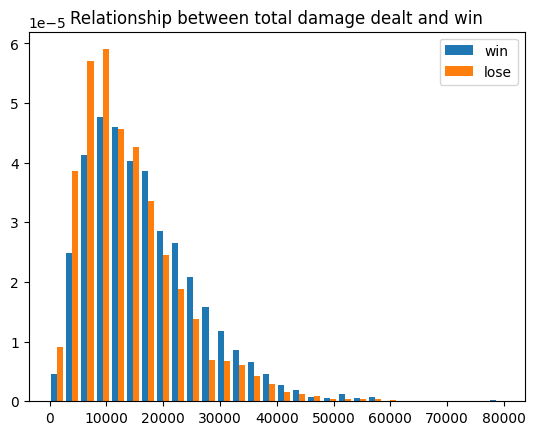

In [48]:
# Relationship between tdd and win
plt.hist([tdd[win == 1], tdd[win == 0]], density=True, bins=30)
plt.legend(['win', 'lose'])
plt.title('Relationship between total damage dealt and win')
plt.show()
# conclusion: the skeweness of the curve is limited by the fact that the game is balanced

In [49]:
def HistByType(data, type, title, bins=30):
    setoftypes = set(type) - {''}
    histo=[]
    for role in setoftypes:
        indices = [i for i, x in enumerate(type) if x == role]
        histo.append(data[indices])
    plt.hist(histo, density=True, bins=bins)
    plt.title(title)
    plt.legend(setoftypes)
    plt.show()

In [50]:
def BoxAndWiskersByType(data, type, title):
    setoftypes = set(type) - {''}
    histo=[]
    for role in setoftypes:
        indices = [i for i, x in enumerate(type) if x == role]
        histo.append(data[indices])
    plt.boxplot(histo)
    plt.title(title)
    plt.legend(setoftypes)
    plt.show()

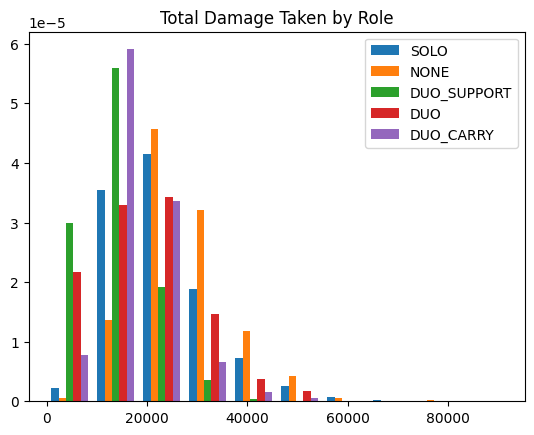

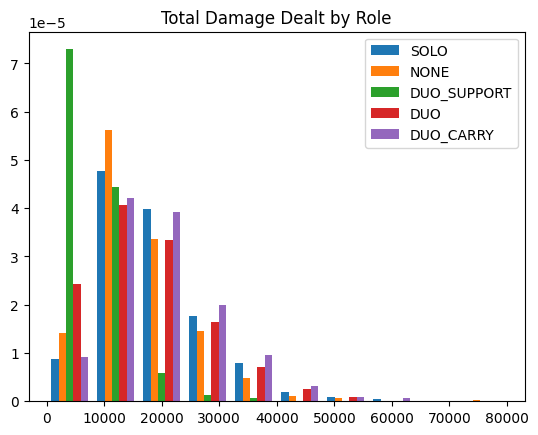

In [51]:
# Relationship between total damage taken and role
HistByType(tdt, participant_role, "Total Damage Taken by Role", bins=10)
# conclusion: the role with the most damage taken is the solo which is expected

# Relationship between total damage dealt and role
HistByType(tdd, participant_role, "Total Damage Dealt by Role", bins=10)
# conclusion: the role with the most damage dealt is the DUO_CARRY which is expected

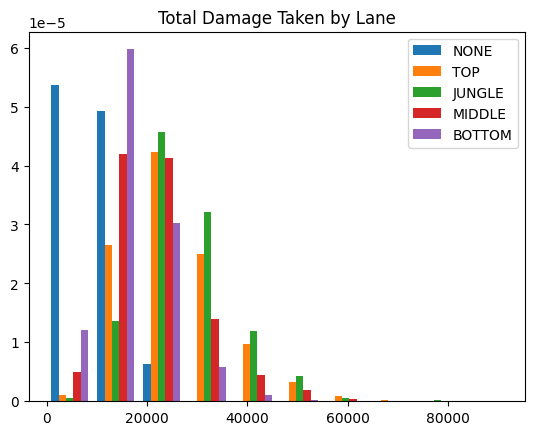

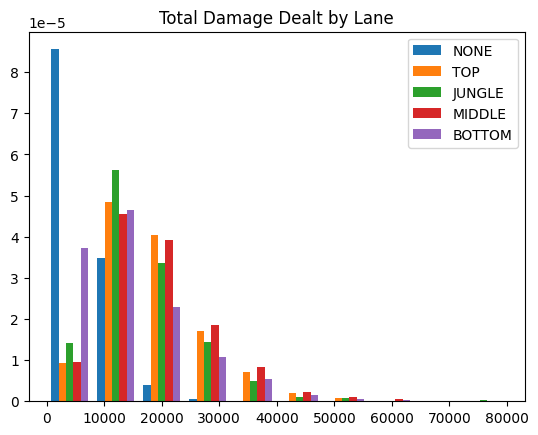

In [52]:
# Relationship between total damage taken and lane
HistByType(tdt, participant_lane, "Total Damage Taken by Lane", bins=10)
# conclusion: the lane with the most damage taken is the jungle lane which is expected

# Relationship between total damage dealt and lane
HistByType(tdd, participant_lane, "Total Damage Dealt by Lane", bins=10)
# conclusion: the lane with the most damage dealt is the bot lane which is expected

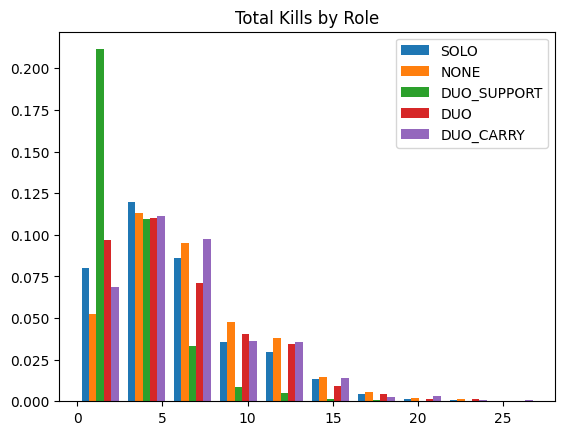

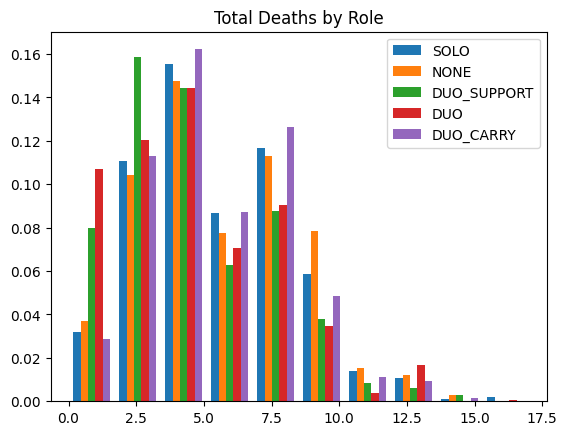

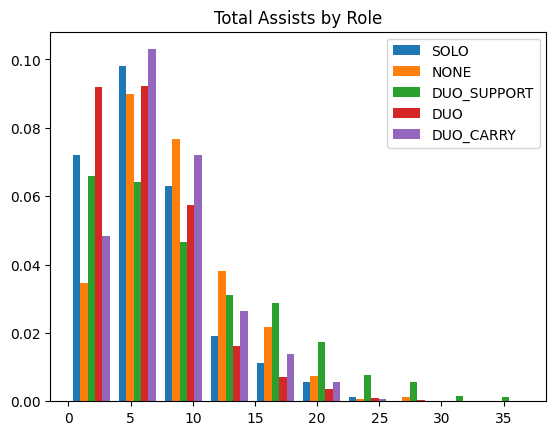

In [53]:
# Relationship between total kills and role
HistByType(kills, participant_role, "Total Kills by Role", bins=10)
# conclusion: the role with the most kills is the Carry

# Relationship between total deaths and role
HistByType(deaths, participant_role, "Total Deaths by Role", bins=10)
# conclusion: the role with the most deaths is the DUO
# the values are very close to each other which indicates that the game is balanced

# Relationship between total assists and role
assists = np_data_participant[:,4]
HistByType(assists, participant_role, "Total Assists by Role", bins=10)
# conclusion: the role with the most assists is the support which is expected